# Datos de corrientes
Este documento se centra sobre la lectura y la representación de datos de corrientes en oceanografía.
![Captura de pantalla de https://earth.nullschool.net](img/currents.png)

La figura es una captura de pantalla de https://earth.nullschool.net, donde observamos las corrientes en el Pacífico Ecuatorial, a una profundidad de 5 metros.

## Cómo se miden las corrientes?       

Existen varias maneras de medir las corrientes a la superficie del océano (mientras la estimación de la velocidad a varias profundidades resulta más complejo)

- con **boyas de derivas** (_drifting buoys_): proporcionan una serie de posiciones, adquiridas por satélite, que permiten estimar la corriente de superficie;
- con un **radar de alta frecuencia** (_HF radar_): proporcionan las corrientes en una zona determinada, gracias a un sistema de antenas;
- con **satélites de altimetría**: las misiones de altimetría proporcionan medidas de anomalías del nivel del mar (_sea level anomalies_), y a partir de ellas se puede derivar las corrientes geostróficas.
- con un **Perfilador Acústico de corrientes Doppler** (_Acoustic Doppler Current Profiler_, ADCP): mide la velocidad a varias distancias del sensor.

In [1]:
import os
import datetime
import numpy as np
from urllib.request import urlretrieve 
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cmocean
mainproj = ccrs.Mercator(central_longitude=-30.0, min_latitude=-20.0, max_latitude=20.0)
datacrs = ccrs.PlateCarree()

## 1. Datos in situ (TBC)
Trabajamos con plataformas in situ obtenidos desde la web de Copernicus Marine Service.

In [2]:
indexlatest = "./index_latest.txt"

In [3]:
indexdata = pd.read_csv(indexlatest, sep=",", header=5)

FileNotFoundError: [Errno 2] No such file or directory: './index_latest.txt'

In [4]:
domain = [-140., -70., -20., 20.]
lon = indexdata["geospatial_lon_min"].values
lat = indexdata["geospatial_lat_min"].values

goodcoords = np.where( (lon<=domain[1]) & (lon>=domain[0]) & (lat<=domain[3]) & (lat>=domain[2]))[0]

NameError: name 'indexdata' is not defined

In [5]:
indexdata["file_name"][goodcoords].values

NameError: name 'indexdata' is not defined

## 2. Modelo
https://data.marine.copernicus.eu/product/GLOBAL_ANALYSISFORECAST_PHY_001_024/description

![Selección de datos desde Copernicus Marine](img/CMEMSdownload.png)

### Fichero de datos

In [6]:
currentfile = "cmems_mod_glo_phy-cur_anfc_0.083deg_P1D-m_1731678780714.nc"
currentfile2 = "cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1731685959908.nc"
if not(os.path.exists(currentfile)):
    urlretrieve("https://dox.uliege.be/index.php/s/mZLCV3TIbqr1Vqw/download", currentfile)
if not(os.path.exists(currentfile2)):
    urlretrieve("https://dox.uliege.be/index.php/s/N24PF6T8LyB3lsx/download", currentfile2)

### Lectura

In [7]:
datacurrent = xr.open_dataset(currentfile)
datacurrent

<xarray.Dataset> Size: 3MB
Dimensions:    (time: 1, depth: 1, latitude: 481, longitude: 840)
Coordinates:
  * time       (time) datetime64[ns] 8B 2024-11-24
  * depth      (depth) float32 4B 0.494
  * latitude   (latitude) float32 2kB -20.0 -19.92 -19.83 ... 19.83 19.92 20.0
  * longitude  (longitude) float32 3kB -140.0 -139.9 -139.8 ... -70.17 -70.08
Data variables:
    uo         (time, depth, latitude, longitude) float32 2MB ...
    vo         (time, depth, latitude, longitude) float32 2MB ...
Attributes:
    Conventions:       CF-1.11
    title:             daily mean fields from Global Ocean Physics Analysis a...
    institution:       Mercator Ocean International
    producer:          CMEMS - Global Monitoring and Forecasting Centre
    source:            MOI GLO12
    credit:            E.U. Copernicus Marine Service Information (CMEMS)
    contact:           https://marine.copernicus.eu/contact
    references:        http://marine.copernicus.eu
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  GLOBAL_ANALYSISFORECAST_PHY_001_024
    subset:datasetId:  cmems_mod_glo_phy-cur_anfc_0.083deg_P1D-m_202406
    subset:date:       2024-11-15T13:53:00.715Z

Preparamos las matrices de coordinadas y de velocidades:    
la funcción `meshgrid` transforma los vectores de coordenadas en matrices bi-dimensionales (necesario para crear las figuras).

In [8]:
lon2d, lat2d = np.meshgrid(datacurrent["longitude"].values, datacurrent["latitude"].values)
u =  datacurrent["uo"][0,0,:,:]
v =  datacurrent["vo"][0,0,:,:]
magnitude = (u ** 2 + v ** 2) ** 0.5

### Por componente

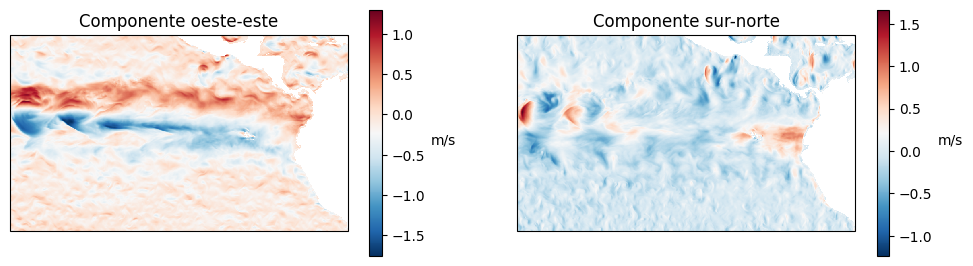

In [9]:
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot(121, projection=mainproj)
pcm1 = ax1.pcolormesh(datacurrent["longitude"], datacurrent["latitude"], u, transform=datacrs, cmap=plt.cm.RdBu_r)
ax1.set_title("Componente oeste-este")
cb1 = plt.colorbar(pcm1, shrink=0.4)
cb1.set_label("m/s", rotation=0, ha="left")

ax2 = plt.subplot(122, projection=mainproj)
pcm2 = ax2.pcolormesh(datacurrent["longitude"], datacurrent["latitude"], v, transform=datacrs, cmap=plt.cm.RdBu_r)
ax2.set_title("Componente sur-norte")
cb2 = plt.colorbar(pcm2, shrink=0.4)
cb2.set_label("m/s", rotation=0, ha="left")
plt.show()

### Vectores
La longitud de cada flecha depende de la velocidad de la corriente.      
Es necesario adaptar los parametros 
- `regrid_shape` (densidad de vectores) y
- `width` (ancho de la flecha)

para obtener una figura visualmente correcta.

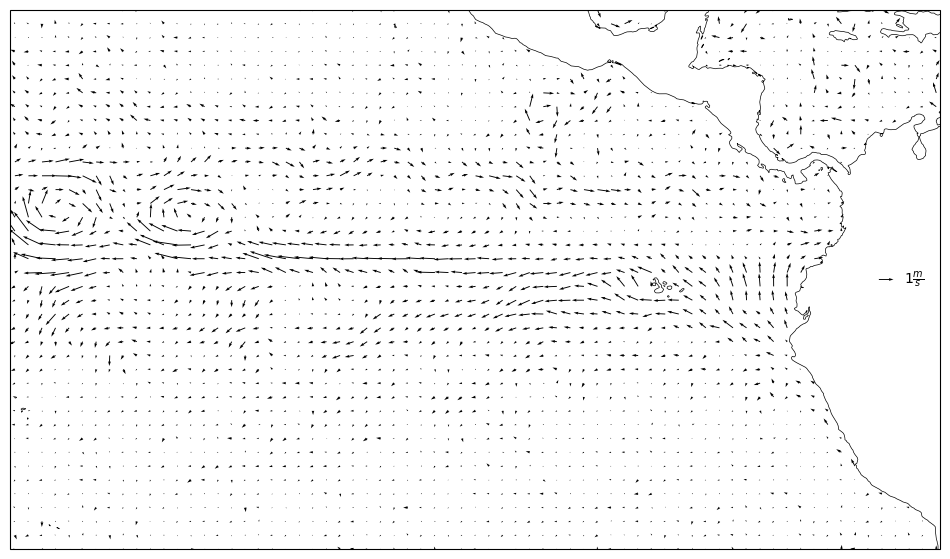

In [12]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection=mainproj)
qv = ax.quiver(datacurrent["longitude"].values, datacurrent["latitude"].values, u, v, 
                  regrid_shape=40, transform=datacrs, width=.001)
qk = ax.quiverkey(qv, 0.95, 0.5, 1, r'$1 \frac{m}{s}$', labelpos='E',
                   coordinates='axes')
ax.set_extent(domain)
ax.coastlines(lw=.5)

### Vectores con colores
El color cambia según la velocidad de la corriente.

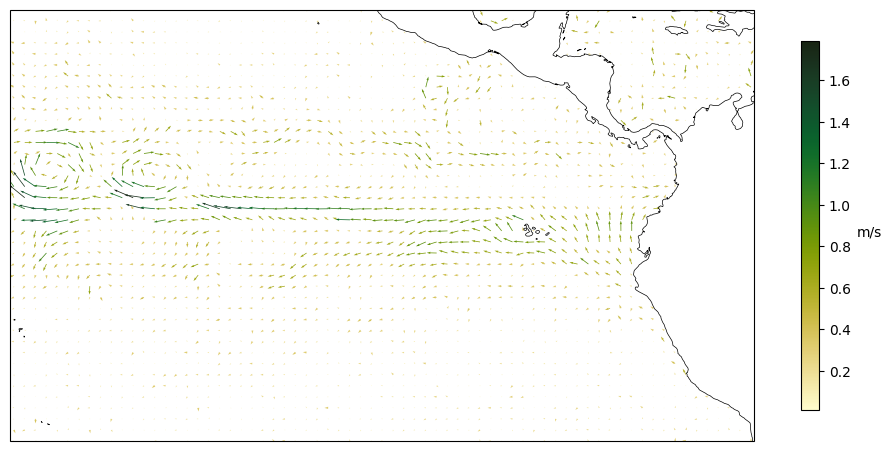

In [13]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection=mainproj)
qv = ax.quiver(datacurrent["longitude"].values, datacurrent["latitude"].values, u, v, magnitude,
                  regrid_shape=40, transform=datacrs, width=.001, cmap=cmocean.cm.speed)
cb = plt.colorbar(qv, shrink=.6)
cb.set_label("m/s", rotation=0, ha="left")
ax.set_extent(domain)
ax.coastlines(lw=.5)

### Línea de corriente
Otra manera de representar el campo de velocidad, a través de las lines de corrientes.     
El parametro `density` controla la densidad de líneas de corriente; aumentar el valor de este parametro aumenta el tiempo de cálculo.

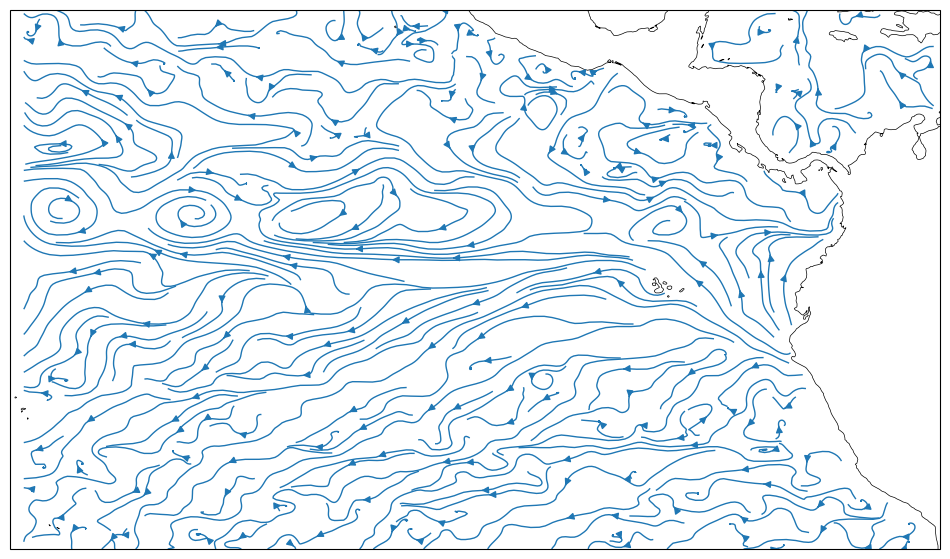

In [14]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection=mainproj)
ax.streamplot(datacurrent["longitude"].values, datacurrent["latitude"].values, u, v, transform=datacrs, 
              linewidth=1, density=10)
ax.set_extent(domain)
ax.coastlines(lw=.5)

## Qué podemos hacer con datos de corriente?
### Simulaciones de trayectorias
Ver el tutorial de Laura.

### Eddy tracking
El `eddy tracking` consiste en detectar los remolinos (_eddies_) a partir de datos de anomalías de nivel del mar y velocidades de corriente, para luego seguir sus desplazamientos (_tracking_). Existen varios algoritmos para esta tarea, aquí trabajamos con el código [PyEddyTracker](https://py-eddy-tracker.readthedocs.io/en/stable/).

![Captura de pantalla de https://earth.nullschool.net](img/remolino.png)


> Mason, E., A. Pascual, and J. C. McWilliams, 2014: A New Sea Surface Height–Based Code for Oceanic Mesoscale Eddy Tracking. _J. Atmos. Oceanic Technol._, **31**, 1181–1188, https://doi.org/10.1175/JTECH-D-14-00019.1. 

In [10]:
import py_eddy_tracker
from py_eddy_tracker.dataset.grid import RegularGridDataset

La primera etapa consiste en leer los datos, en este caso de altimetría, indicando los nombres de las variables que contienen las coordenadas:

In [11]:
h = RegularGridDataset(currentfile2, "longitude", "latitude")

We assume pixel position of grid is centered for cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1731685959908.nc


En la segunda etapa, se aplica y filtro de paso alto (para atenúar los componentes de baja frecuencia).

In [12]:
h.bessel_high_filter("adt", 500, order=3)

En la etapa final, se procede a la detección de los remolinos. Indicamos
- la variable de altimetría utilizada para la detección (suele ser ´adt´ o ´sla´)
- las variables que contienen la velocidad (`ugos` y `vgos`)
- el tiempo (tiene que corresponder con el periodo de datos disponibles en el fichero, en este caso desde enero 2023 hasta junion 2023)
- otros parametros que permiten afinar la detección.

In [14]:
a, c = h.eddy_identification(
    "adt",
    "ugos",
    "vgos",  # Variables used for identification
    datetime.datetime(2023, 1, 5),  # Date of identification
    0.001,  # step between two isolines of detection (m)
    pixel_limit=(5, 500),  # Min and max pixel count for valid contour
    shape_error=55,  # Error max (%) between ratio of circle fit and contour
)

/home/ctroupin/.virtualenvs/Prout/lib/python3.10/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


La ejecución de `eddy_identification` crea como resultado `a` (remolinos anticiclónicos) y `c` (remolinos ciclónicos). 

### Figuras
Representamos los remolinos en el mapa.

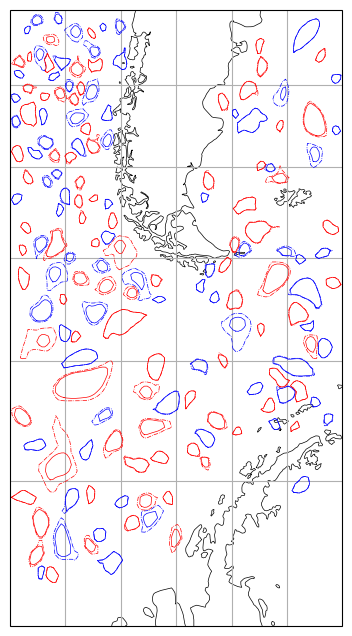

In [17]:
mainproj2 = ccrs.Mercator(central_longitude=-60.0, min_latitude=-70.0, max_latitude=0.)

fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection=mainproj2)
ax.set_extent([-85, -55., -70., -40.])
ax.gridlines()
ax.coastlines(lw=.5)
a.display(ax, color="b", linewidth=0.5, transform=ccrs.PlateCarree())
c.display(ax, color="r", linewidth=0.5, transform=ccrs.PlateCarree())

plt.show()

In [18]:
### Características de los remolinos
#### Radio

array([ 36173.18 ,  42069.38 ,  29925.572,  27064.367,  18384.91 ,
        25510.969,  42461.633,  51822.816,  37826.113,  22355.693,
        24857.469,  64450.504,  36372.33 ,  56416.176,  36958.645,
        23954.172,  47588.5  ,  67336.42 ,  72658.88 ,  25104.438,
        23352.93 ,  83604.19 ,  65109.918,  30153.11 ,  39292.023,
        25449.525,  44186.63 ,  43074.14 ,  51532.902,  34736.45 ,
        30846.441,  48534.84 ,  28900.39 ,  46465.5  ,  24895.086,
        57826.25 ,  37303.637,  40322.465,  34001.293,  51944.21 ,
        75720.61 ,  24658.08 ,  36419.32 ,  81330.27 ,  43741.992,
        34120.746,  28852.682,  25719.291,  31296.262,  50169.863,
        64658.72 ,  61949.164,  40326.355,  67733.07 ,  32991.227,
        28561.059,  42333.402,  63904.594,  43729.71 ,  55459.94 ,
        75459.89 ,  39816.543,  63297.78 ,  71056.77 ,  31965.17 ,
        38993.66 ,  24943.035,  25311.734,  41605.25 ,  34189.83 ,
        36266.08 ,  28925.13 , 102981.21 ,  34222.37 ,  36843.

Text(0.5, 0, 'Radio (m)')

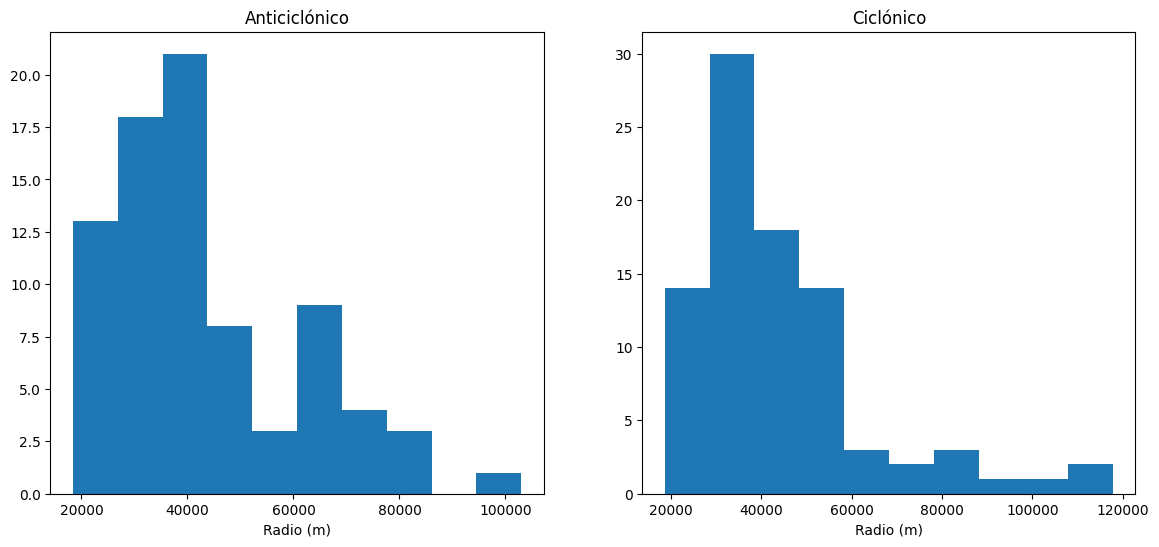

In [23]:
fig = plt.figure(figsize=(14, 6))
ax = plt.subplot(121)
ax.hist(a.effective_radius)
ax.set_title("Anticiclónico")
ax.set_xlabel("Radio (m)")
ax = plt.subplot(122)
ax.hist(c.effective_radius)
ax.set_title("Ciclónico")
ax.set_xlabel("Radio (m)")

In [ ]:
a.